# Amplitude Source Location (ASL)

## 1. Introduction

### 1.1 Review

In the previous tutorial, we estimated Reduced Displacement by assuming a source location, e.g. the summit of a volcano. But it would be better if we locate volcano-seismic signals, and then compute Reduced Displacement. Most volcano-seismic signals cannot be located using traditional differential travel-time techniques, because they lack identifiable phases (sources are quasi-continuous, so phases are arriving all the time). So what else can we do?

### 1.2 Motivation
In summer 1996, I was fortunate enough as a graduate student to be asked to assist the British Geological Survey in its monitoring of the Soufriere Hills Volcano, Montserrat. As part of "Team Seismic" at the Montserrat Volcano Observatory, our job was to provide 24-7 monitoring of the lava dome eruption, which had been continuous since October 1995. Crucially, this involved two-way radio communications with others working on the slopes of the volcano, and warning them of seismicity, especially pyroclastic flows [Add video here from Lauren's Journeys program]. 

I had the idea that we could use the RSAM data to locate seismicity continuously, on a map on a monitor in the Ops Room. I created a proof-of-concept, using the 60-s RSAM data (the 2.56-s RSAM data wasn't captured), and applying calibration constants. We'll replicate that here, but use DSAM data, which has already been instrument-corrected. For simplicity - and speed which was important for a real-time system - we ignore the vertical dimension (topography and station elevations ignored), and assume an isotropic, homogeneous half-space.

First, we will run a simulation, to demonstrate that our location technique works. Then we will compute locations for real DSAM data, and then for a known pyroclastic flow signal.

### 1.3 Setup

We need to import the following, to set things up.

In [ ]:
import os
import sys
#from pathlib import Path
import numpy as np
import obspy
localLibPath = os.path.join('..', 'lib')
sys.path.append(localLibPath)
from SAM import DSAM
from ASL import montserrat_topo_map, Grid, ASL, simulate_DSAM, plot_DSAM
SDS_DIR = '/data/SDS' #'/Volumes/NTFS_2TB_EXT/SDS'
HOME = os.path.expanduser('~')
DATA_DIR = os.path.join(HOME, 'Dropbox/BRIEFCASE/MESS2024/skience2024_GTplus/02 Volcano Monitoring/data')
SAM_DIR = os.path.join(DATA_DIR,'continuous','SAM')
SAM_DIR = '/data/SAM' #os.path.join(DATA_DIR,'continuous','SAM')
DEM_DIR = os.path.join(DATA_DIR,'DEMs')
RESPONSE_DIR = os.path.join(DATA_DIR,'responses')

## 2. Synthetic testing

### 2.1 Map of Montserrat stations
We generate a map of seismic stations with a vertical-component sensor, operational (though not necessarily working properly) on July 12, 2003. This 13-station network provides good azimuthal coverage.

In [ ]:
invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
invMVO = invMVO.select(starttime=startt, endtime=endt)
invMVO = invMVO.select(channel='*Z')
#import pygmt
#pygmt.config(GMT_DATA_SERVER="https://oceania.generic-mapping-tools.org")
montserrat_topo_map(inv=invMVO, show=True, add_labels=True, resolution='03s', DEM_DIR=DEM_DIR);

### 2.2 Define a grid of source locations and reduced displacement at those nodes

In [ ]:
sampling_interval = 60
synthetic_source = {}
N = 10
synthetic_source['lat'] = 16.69 + np.tile(np.arange(N)/200, N)
synthetic_source['lon'] = -62.20 + np.repeat(np.arange(N)/200, N)
synthetic_source['DR'] = np.ones(N*N) * 100.0 # 100 cm^2 everywhere
synthetic_source['t'] = [obspy.UTCDateTime(0) + t * sampling_interval for t in range(N*N)]
#print(synthetic_source)

surfaceWaveSpeed_kms = 1.5
peakf=8.0
Q=23
synthDSAMobj = simulate_DSAM(invMVO, synthetic_source, surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, \
                             peakf=peakf, Q=Q, noise_level_percent=0.0)
synthDSAMobj.plot(metrics='mean')

### 2.3 Create grid with 100-m node spacing, 8 x 10 km 

In [ ]:
node_spacing_m = 100
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(np.mean(synthetic_source['lat']), np.mean(synthetic_source['lon']), nlat, nlon, node_spacing_m)  
gridobj.plot(node_spacing_m = node_spacing_m, DEM_DIR=DEM_DIR)

In [ ]:
##print(synthDSAMobj)
#plot_DSAM(synthDSAMobj, gridobj, 99, metric='mean', DEM_DIR=DEM_DIR) # getting some error about GMTInvalidInput: Too much data. Use either data or x/y/z. commented out on 22/02/2025

### 2.4 Plot synthetic source locations, and DR time series (all equal=100 ${cm}^2$)

In [ ]:
aslobj = ASL(synthDSAMobj, 'mean', invMVO, gridobj)

aslobj.plot(synthetic_source, zoom_level=1, threshold_DR=1.0, scale=0.1)

### 2.5 Run location algorithm on synthetic source and plot resulting locations and DR time series

In [ ]:
import time
aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf=peakf)

### slow location algorithm

In [ ]:
time1 = time.time()
source = aslobj.locate()
time2 = time.time()
print(f'Location algorithm took {time2-time1} s')
aslobj.plot(source, zoom_level=1, scale=0.1, threshold_DR=0.0)

### fast location algorithm

In [ ]:
time1 = time.time()
fast_source = aslobj.fast_locate()
time2 = time.time()
print(f'Vectorized location algorithm took {time2-time1} s')
aslobj.plot(fast_source, zoom_level=1, scale=0.1, threshold_DR=0.0)

## 3 Locating real DSAM data: July 12, 2003 collapse

Now we are confident in our ability to locate synthetic data correctly, and determine reduced displacement correctly, we will try to locate some real data. In this example, we use the 'VT' metric from the DSAM dataset. Recall that this is the mean amplitude of the signal (over 60-s time windows) after filtering between 4 and 18 Hz, rather than the 'mean' metric (or 'median', or 'rms' etc.) which are computed on signals filtered between 0.5 and 18 Hz. We do this because Jolly et al. (2002) determined that a 7-9 Hz bandpass was best for locating pyroclastic flows, and so the VT band is the one we have available that best matches this.

### 3.1 Read inventory and DSAM data. Plot DSAM data

In [ ]:
invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')
startt = obspy.UTCDateTime(2003,7,12,23,0,0)
endt = obspy.UTCDateTime(2003,7,13,4,0,0)
dsamObj = DSAM.read(startt, endt, SAM_DIR=SAM_DIR, sampling_interval=60, ext='pickle', \
                     trace_ids=['MV.MBGH..BHZ', 'MV.MBLG..SHZ', 'MV.MBRY..BHZ', 'MV.MBSS..SHZ', 'MV.MBWH..SHZ'])  

dsamObj.plot(metrics='VT')

### 3.2 Create dense grid (20-m node spacing) and plot

In [ ]:
source = {'lat':16.71111, 'lon':-62.17722}
node_spacing_m = 20
grid_size_lat_m = 10000
grid_size_lon_m = 8000
nlat = int(grid_size_lat_m/node_spacing_m) + 1
nlon = int(grid_size_lon_m/node_spacing_m) + 1
gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  
gridobj.plot(node_spacing_m = node_spacing_m)

### 3.3 Create ASL object, compute combined geometrical spreading and inelatic attenuation corrections for each node

In [ ]:
Q = 23
surfaceWaveSpeed_kms = 1.5 # km/s
peakf = 8.0

aslobj = ASL(dsamObj, 'rms', invMVO, gridobj)

aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=Q, fix_peakf = peakf)

### 3.4 Run the amplitude location

In [ ]:
source = aslobj.fast_locate()

### 3.5 Plot sources and source reduced displacements

In [ ]:
aslobj.plot(source, zoom_level=2, threshold_DR=100.0, scale=0.1)
aslobj.plot(source, zoom_level=0, threshold_DR=100.0, scale=0.1)

## 4. Locate a pyroclastic flow

In [ ]:
import os
import sys
import numpy as np
import time
import obspy
from obspy import read_inventory
sys.path.append('../lib')
from SAM import DSAM
from ASL import montserrat_topo_map, Grid, ASL, simulate_DSAM
from obspy.clients.filesystem.sds import Client
import SDS
sdsclient = Client(SDS_DIR)
myclient = SDS.SDSobj(SDS_DIR, sds_type='D', format='MSEED')
#print(SDS_DIR)
#print(os.listdir(os.path.join(SDS_DIR, '2003')))
eventtime = obspy.UTCDateTime(2003, 7, 11, 4, 6, 0)
#eventtime = obspy.UTCDateTime(2003, 7, 11)
print(eventtime.julday)
st = obspy.Stream()
if sdsclient.get_all_nslc(eventtime):
    print('Using regular sdsclient')
    st = sdsclient.get_waveforms("MV", "*", "", "*Z", eventtime, eventtime+180)
else:
    print('Using myclient')
    myclient.read(eventtime, eventtime+180, skip_low_rate_channels=True, trace_ids=None, speed=1, verbose=True )
    st = myclient.stream
if len(st)>0:
    st.plot(equal_scale=False);

    # same parameters as before
    Q = 23
    surfaceWaveSpeed_kms = 1.5 # km/s
    peakf = 8.0

    # same grid as before
    source = {'lat':16.71111, 'lon':-62.17722}
    #node_spacing_m = 20
    node_spacing_m = 100
    grid_size_lat_m = 10000
    grid_size_lon_m = 8000
    nlat = int(grid_size_lat_m/node_spacing_m) + 1
    nlon = int(grid_size_lon_m/node_spacing_m) + 1
    gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  

    # Load inventory
    invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')

    # remove instrument response - and set units accordingly IMPORTANT!
    pre_filt = [0.4, 0.5, 18, 20]
    #pre_filt = [6.0, 7.0, 9.0, 10.0]
    for tr in st:
        print(tr)
        try:
            tr.remove_response(inventory=invMVO, pre_filt=pre_filt, output="DISP", plot=True) 
        except:
            st.remove(tr)
        else:
            tr.stats['units'] = 'm'
    #st.plot(equal_scale=True);

    # compute DSAM data with 10-s time window
    dsamObj = DSAM(stream=st, sampling_interval=10)
    print(dsamObj)
    dsamObj.plot(metrics='rms', equal_scale=True)
else:
    print('No data for this event')

['/data/SEISAN_DB/REA/MVOE_/2001/01/01-0007-02L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0010-00L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0026-17L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0028-27L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0037-50L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0040-14L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0104-44L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0115-13L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0122-30L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0140-10L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0220-57L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0222-13L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0223-34L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0235-55L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0236-50L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0241-17L.S200101', '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0250-05L.S200101', '/data/SEISAN_DB/REA/MVOE_/200

{'path': '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0007-02L.S200101',
 'filetime': datetime.datetime(2001, 1, 1, 0, 7, 2),
 'mainclass': 'LV',
 'subclass': 'r',
 'wavfile1': '/data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0007-02S.MVO___019',
 'wavfile2': None,
 'num_magnitudes': 0,
 'magnitude': None,
 'magnitude_type': None,
 'num_wavfiles': 1,
 'num_aeffiles': 0,
 'located': False,
 'num_arrivals': 0,
 'error_exists': False,
 'focmec_exists': False}

got 0 similar wavfiles matching /data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0007-*
Parsing  /data/SEISAN_DB/REA/MVOE_/2001/01/01-0010-00L.S200101


{'path': '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0010-00L.S200101',
 'filetime': datetime.datetime(2001, 1, 1, 0, 10),
 'mainclass': 'LV',
 'subclass': 'l',
 'wavfile1': '/data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0010-00S.MVO___019',
 'wavfile2': None,
 'num_magnitudes': 0,
 'magnitude': None,
 'magnitude_type': None,
 'num_wavfiles': 1,
 'num_aeffiles': 0,
 'located': False,
 'num_arrivals': 0,
 'error_exists': False,
 'focmec_exists': False}

got 0 similar wavfiles matching /data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0010-*
Parsing  /data/SEISAN_DB/REA/MVOE_/2001/01/01-0026-17L.S200101


{'path': '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0026-17L.S200101',
 'filetime': datetime.datetime(2001, 1, 1, 0, 26, 17),
 'mainclass': 'LV',
 'subclass': 'r',
 'wavfile1': '/data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0026-17S.MVO___019',
 'wavfile2': None,
 'num_magnitudes': 0,
 'magnitude': None,
 'magnitude_type': None,
 'num_wavfiles': 1,
 'num_aeffiles': 0,
 'located': False,
 'num_arrivals': 0,
 'error_exists': False,
 'focmec_exists': False}

got 0 similar wavfiles matching /data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0026-*
Parsing  /data/SEISAN_DB/REA/MVOE_/2001/01/01-0028-27L.S200101


{'path': '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0028-27L.S200101',
 'filetime': datetime.datetime(2001, 1, 1, 0, 28, 27),
 'mainclass': 'LV',
 'subclass': 'r',
 'wavfile1': '/data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0028-27S.MVO___019',
 'wavfile2': None,
 'num_magnitudes': 0,
 'magnitude': None,
 'magnitude_type': None,
 'num_wavfiles': 1,
 'num_aeffiles': 0,
 'located': False,
 'num_arrivals': 0,
 'error_exists': False,
 'focmec_exists': False}

got 0 similar wavfiles matching /data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0028-*
Parsing  /data/SEISAN_DB/REA/MVOE_/2001/01/01-0037-50L.S200101


{'path': '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0037-50L.S200101',
 'filetime': datetime.datetime(2001, 1, 1, 0, 37, 50),
 'mainclass': 'LV',
 'subclass': 'r',
 'wavfile1': '/data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0037-50S.MVO___019',
 'wavfile2': None,
 'num_magnitudes': 0,
 'magnitude': None,
 'magnitude_type': None,
 'num_wavfiles': 1,
 'num_aeffiles': 0,
 'located': False,
 'num_arrivals': 0,
 'error_exists': False,
 'focmec_exists': False}

got 0 similar wavfiles matching /data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0037-*
Parsing  /data/SEISAN_DB/REA/MVOE_/2001/01/01-0040-14L.S200101


{'path': '/data/SEISAN_DB/REA/MVOE_/2001/01/01-0040-14L.S200101',
 'filetime': datetime.datetime(2001, 1, 1, 0, 40, 14),
 'mainclass': 'LV',
 'subclass': 'r',
 'wavfile1': '/data/SEISAN_DB/WAV/MVOE_/2001/01/2001-01-01-0040-14S.MVO___019',
 'wavfile2': None,
 'num_magnitudes': 0,
 'magnitude': None,
 'magnitude_type': None,
 'num_wavfiles': 1,
 'num_aeffiles': 0,
 'located': False,
 'num_arrivals': 0,
 'error_exists': False,
 'focmec_exists': False}

19 Trace(s) in Stream:
MV.MBRY..BHZ | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBRY..BHN | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBRY..BHE | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBSS..SHZ | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBBY..BHZ | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBBY..BHN | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBBY..BHE | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBGH..BHZ | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBGH..BHN | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBGH..BHE | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBWH

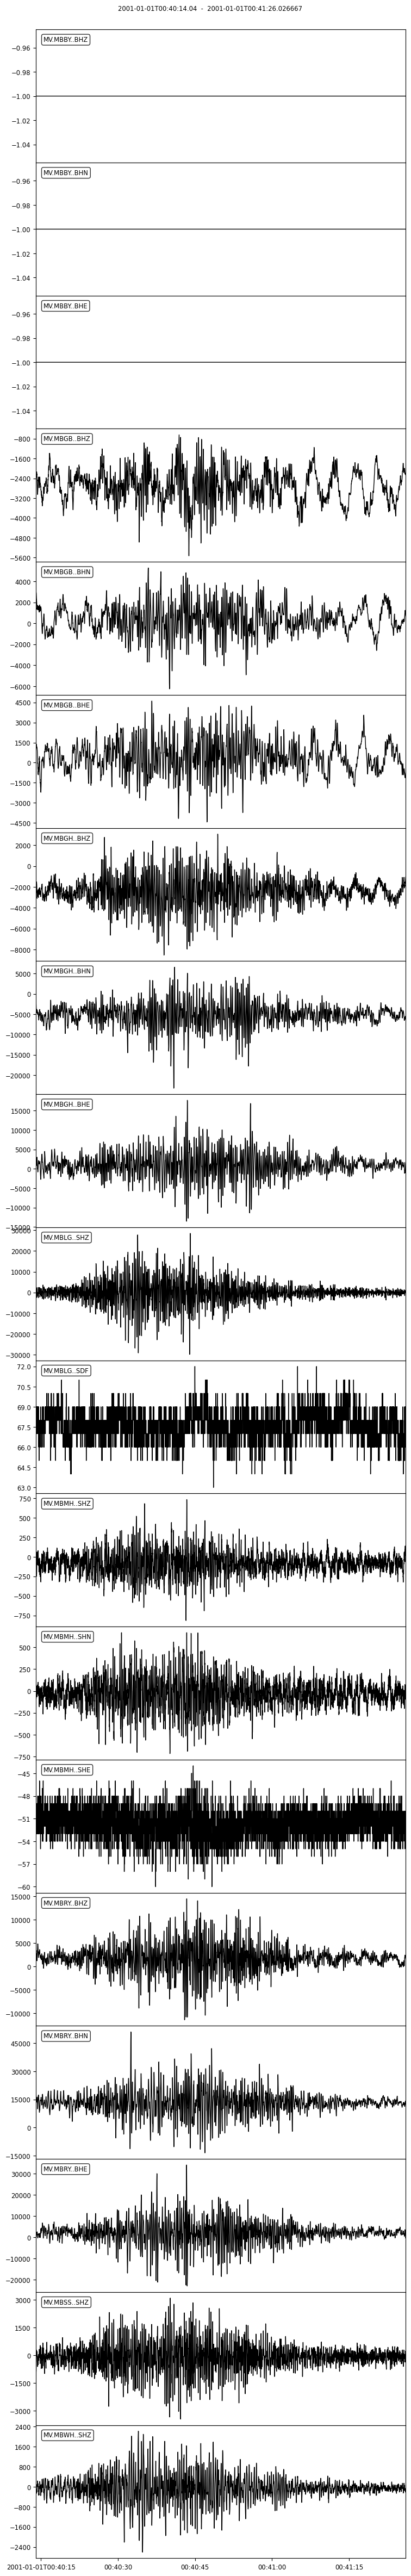

MV.MBRY..BHZ | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBRY..BHN | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBRY..BHE | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBSS..SHZ | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBBY..BHZ | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBBY..BHN | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBBY..BHE | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBGH..BHZ | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBGH..BHN | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBGH..BHE | 2001-01-01T00:40:14.040000Z - 2001-01-01T00:41:26.026667Z | 75.0 Hz, 5400 samples
MV.MBWH..SHZ | 2001-01-01T00:4

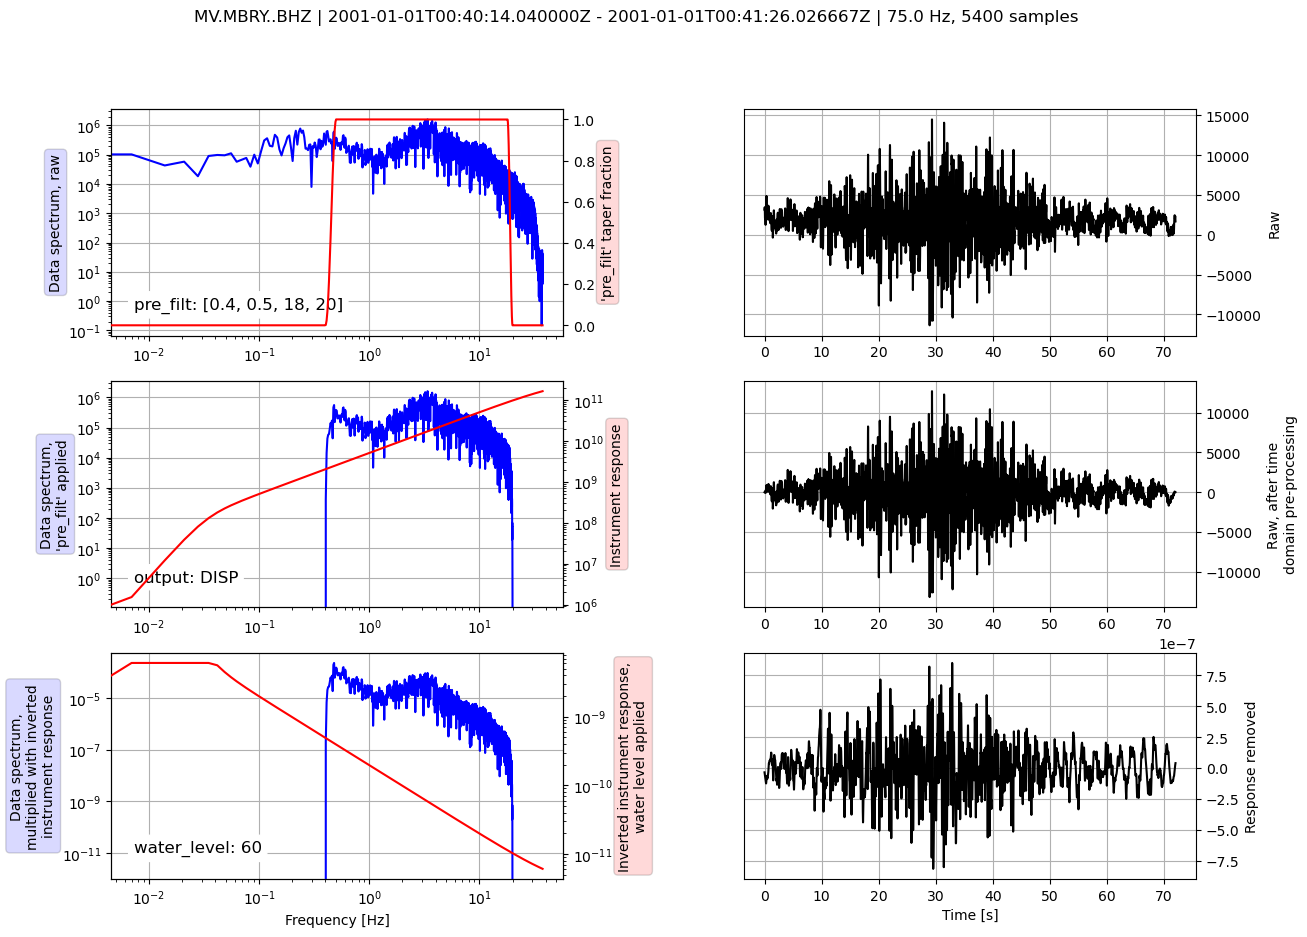

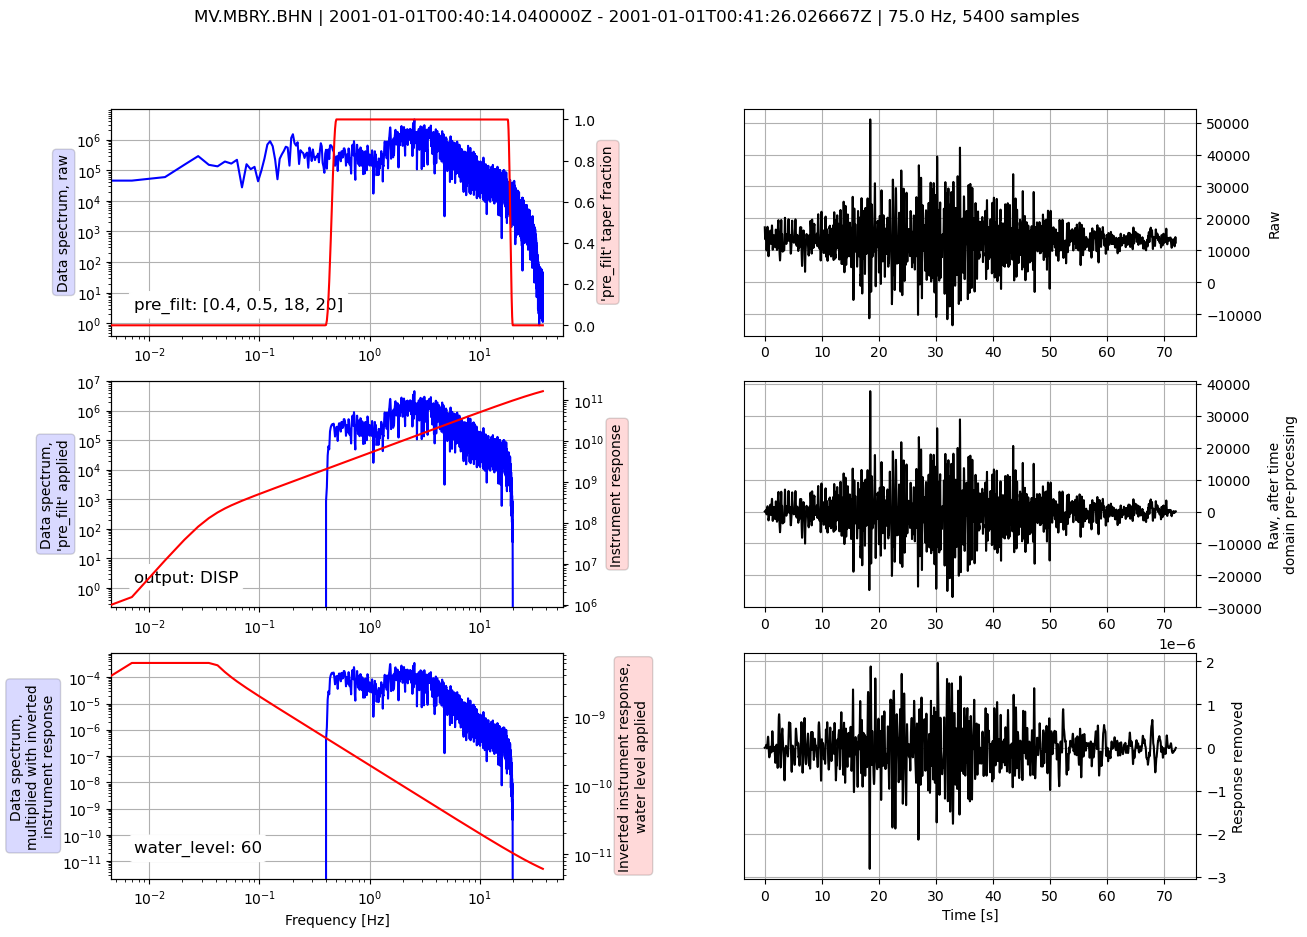

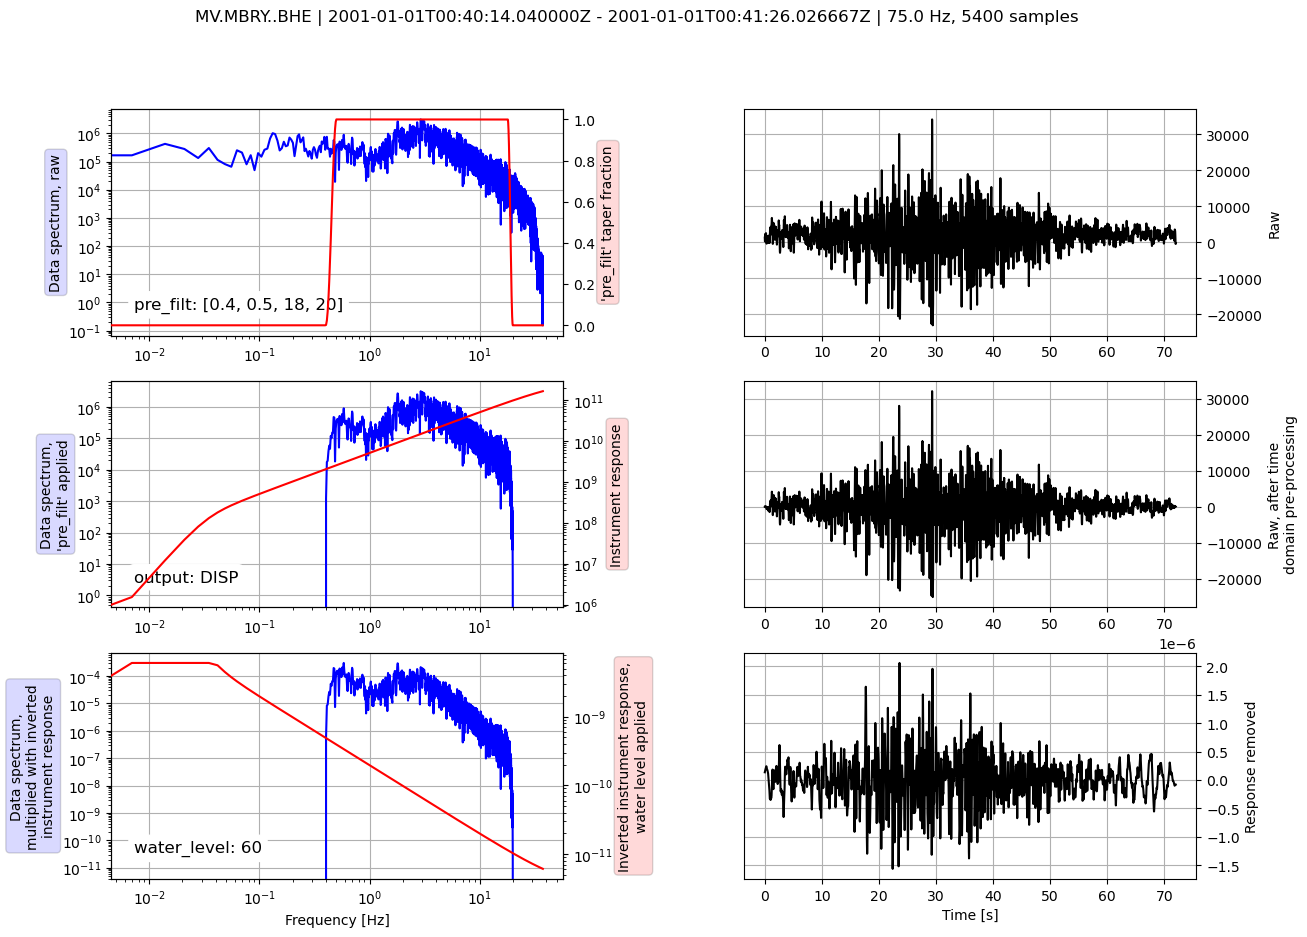

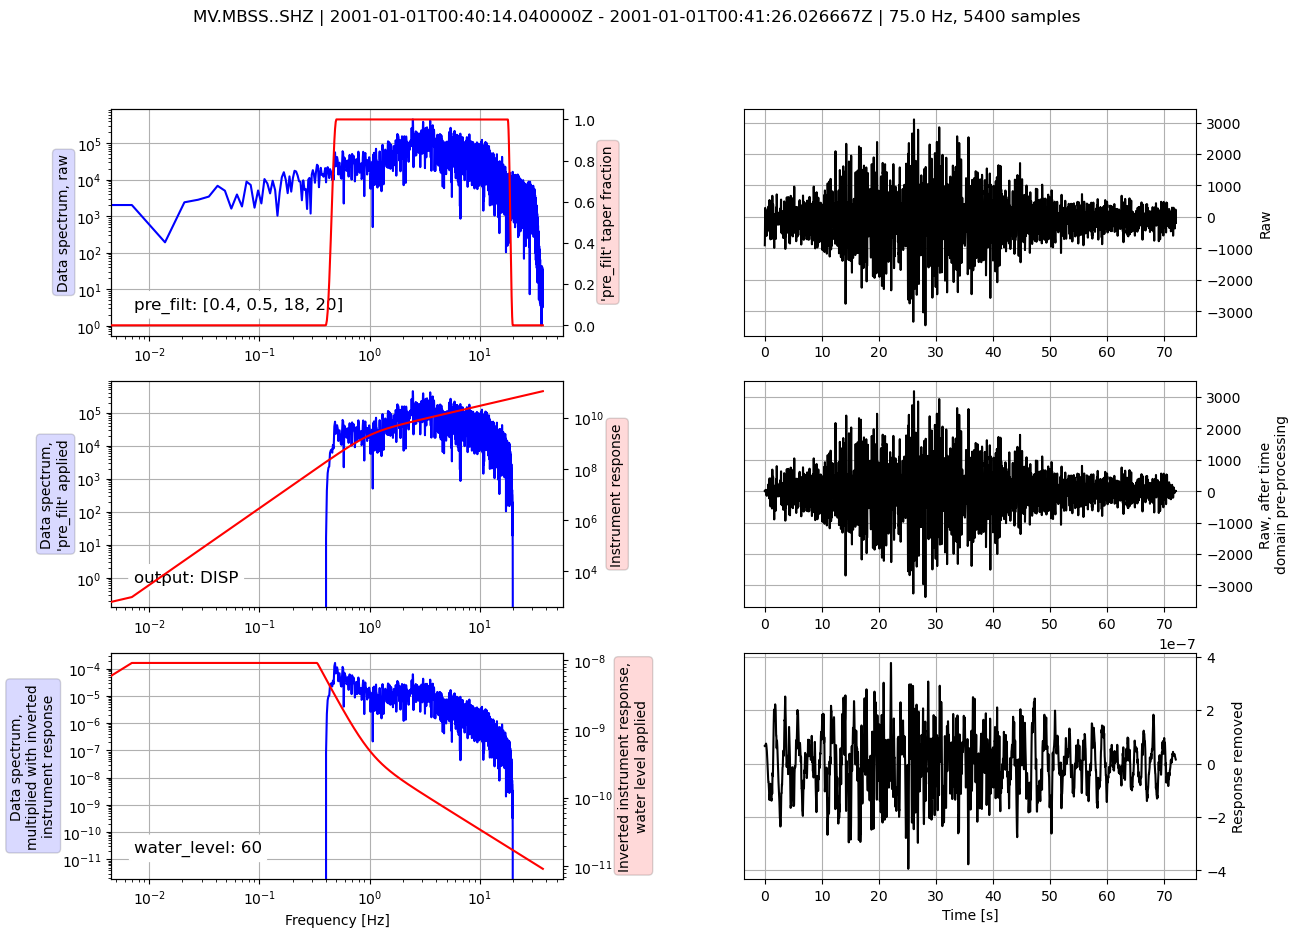

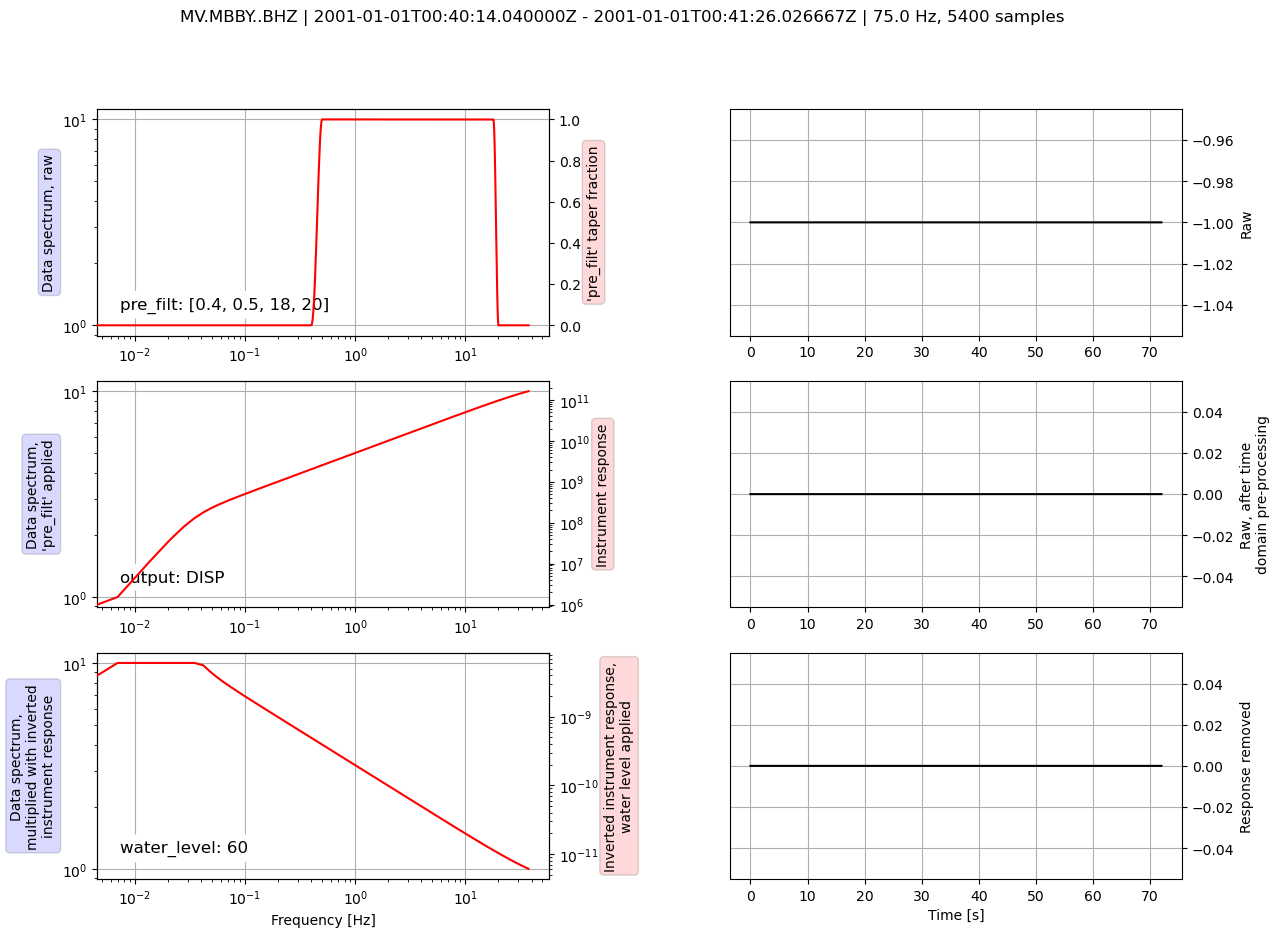

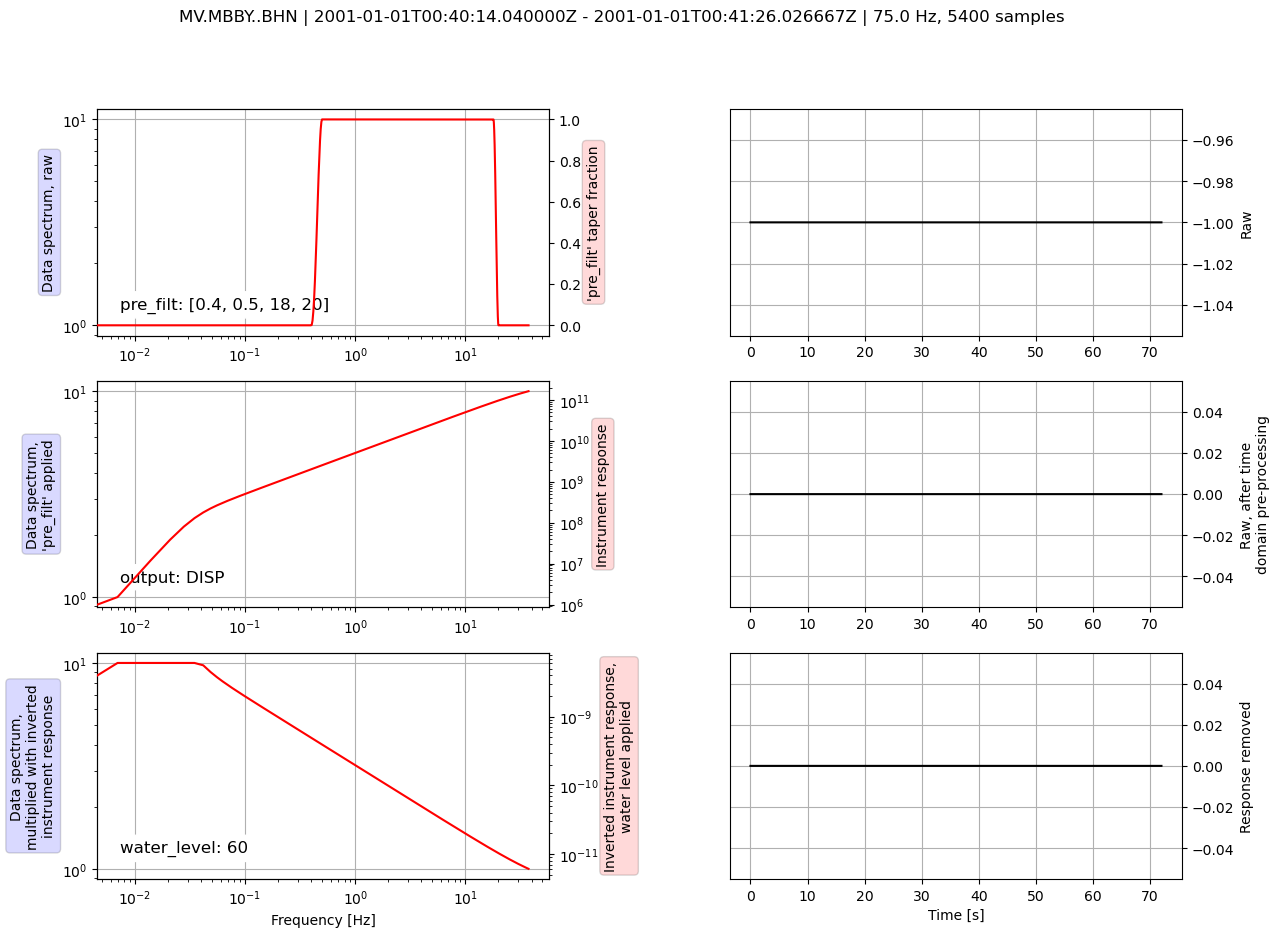

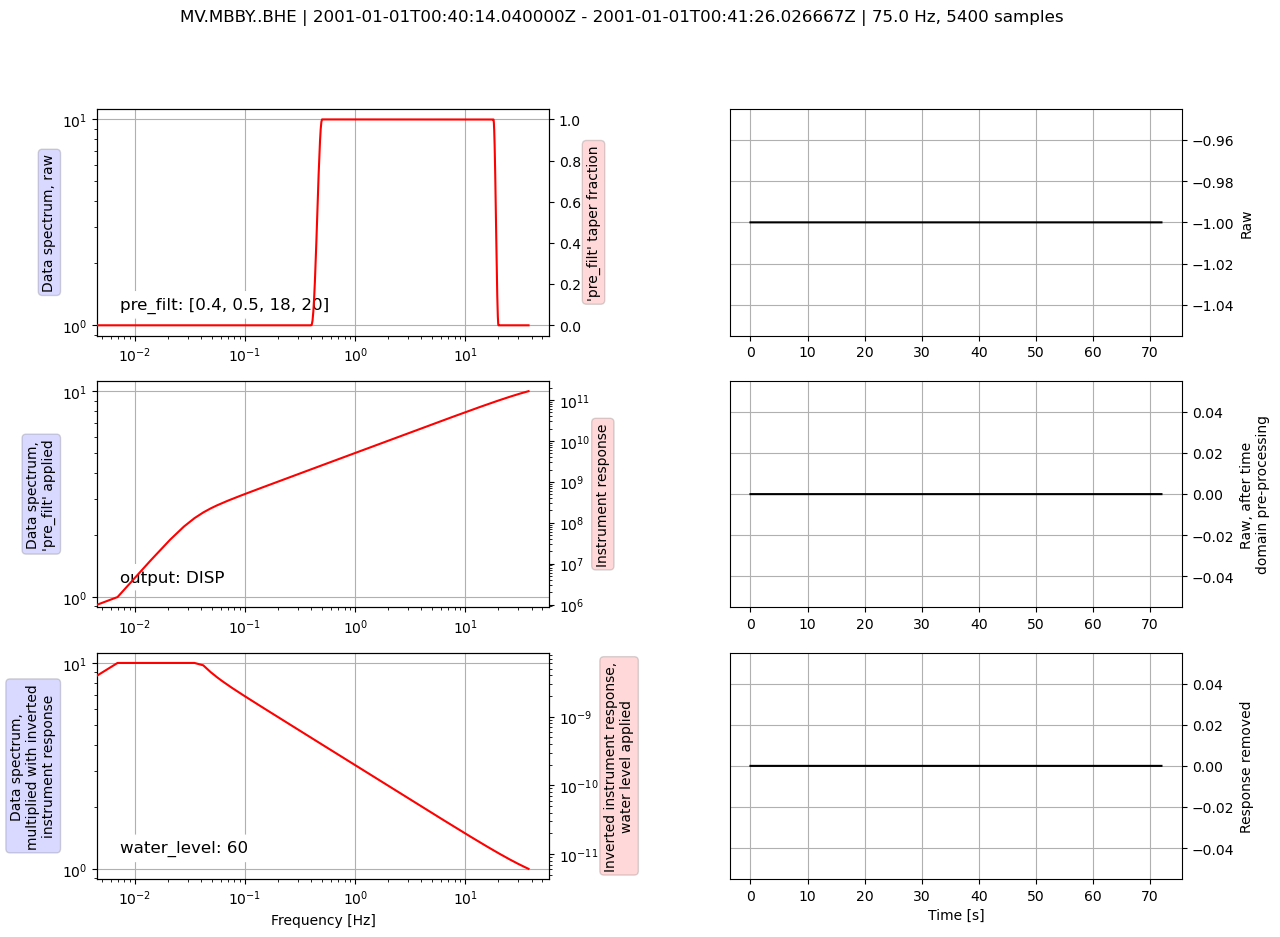

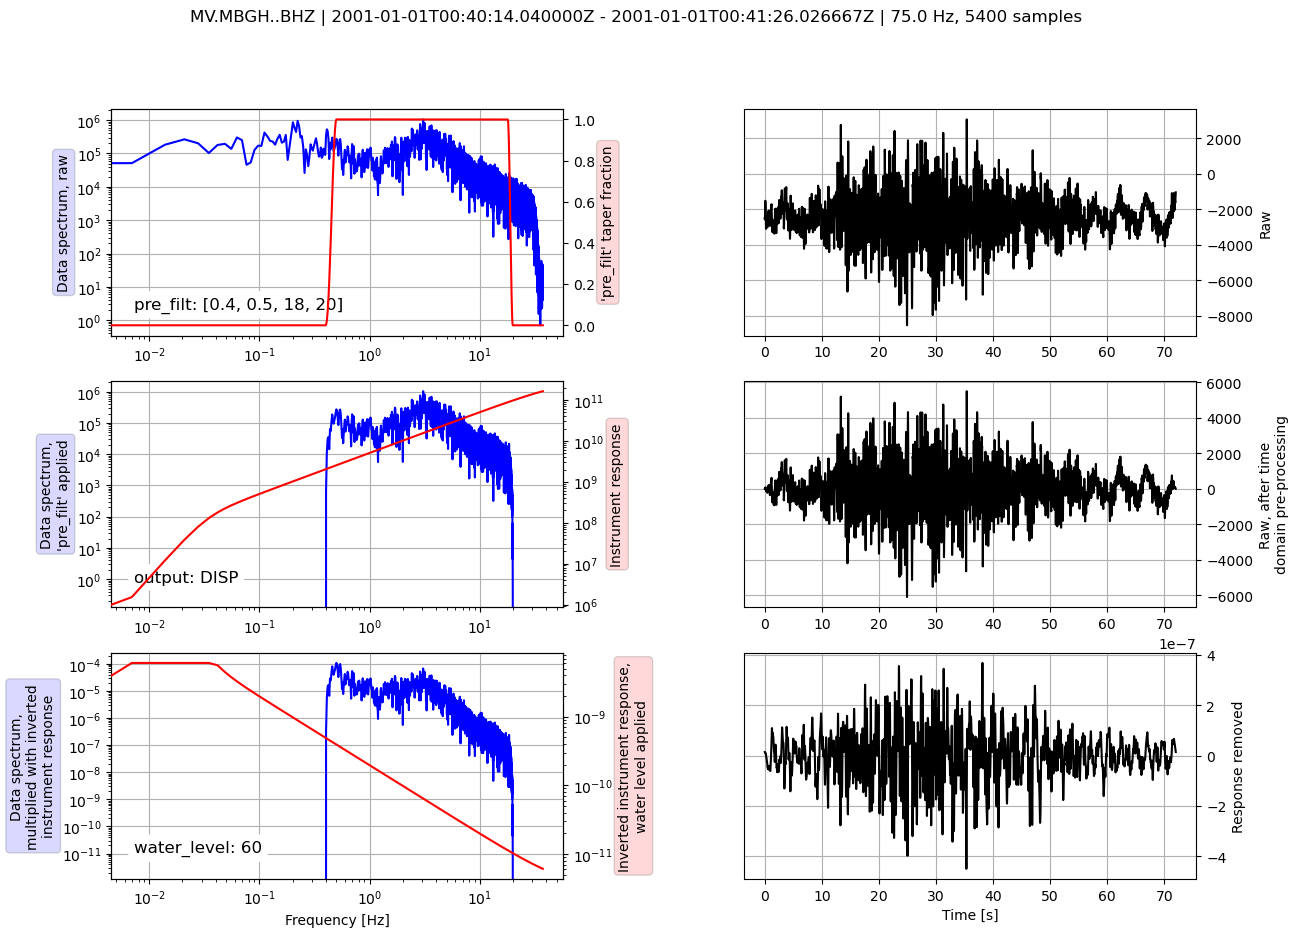

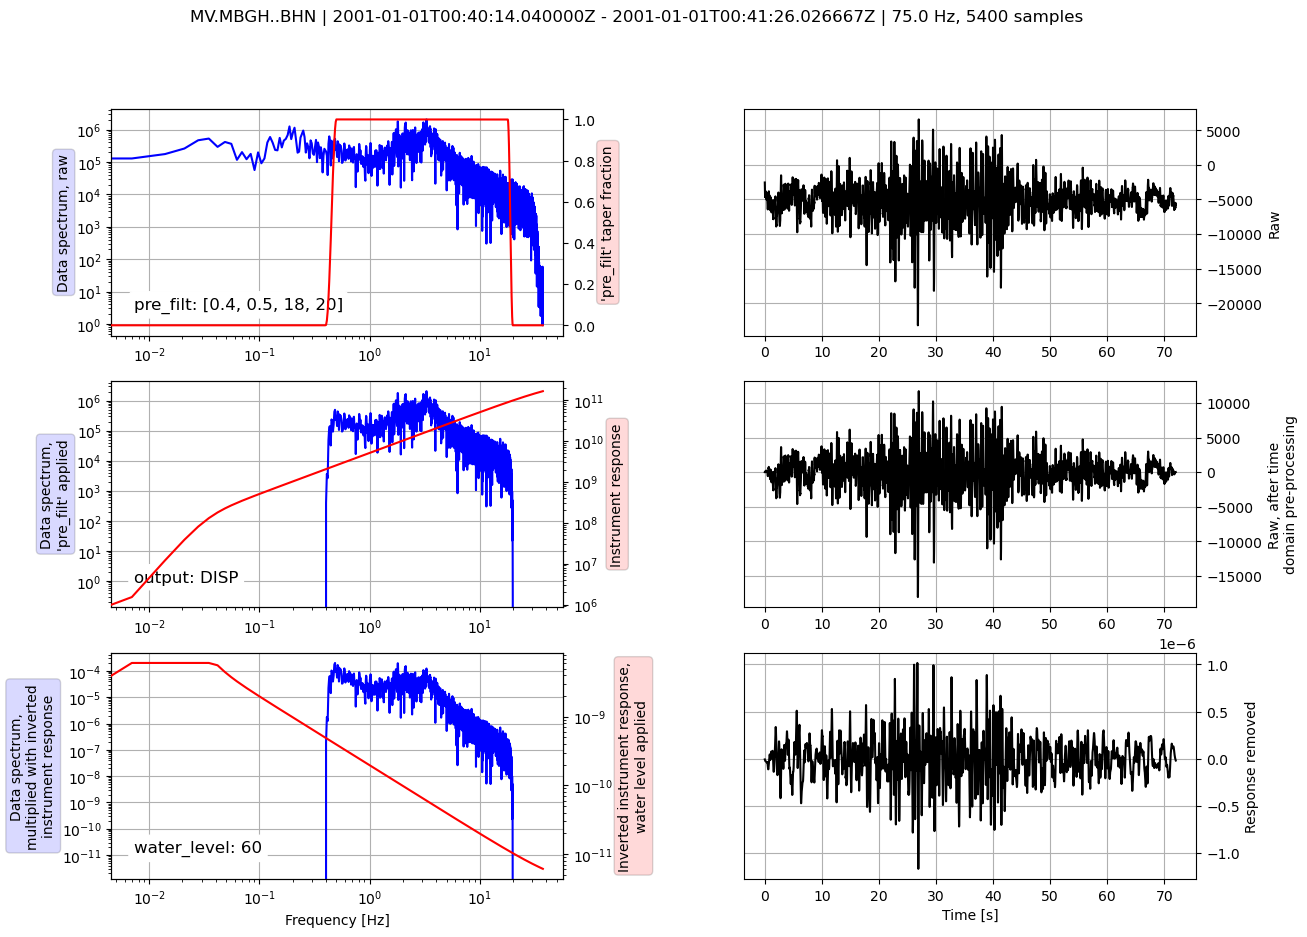

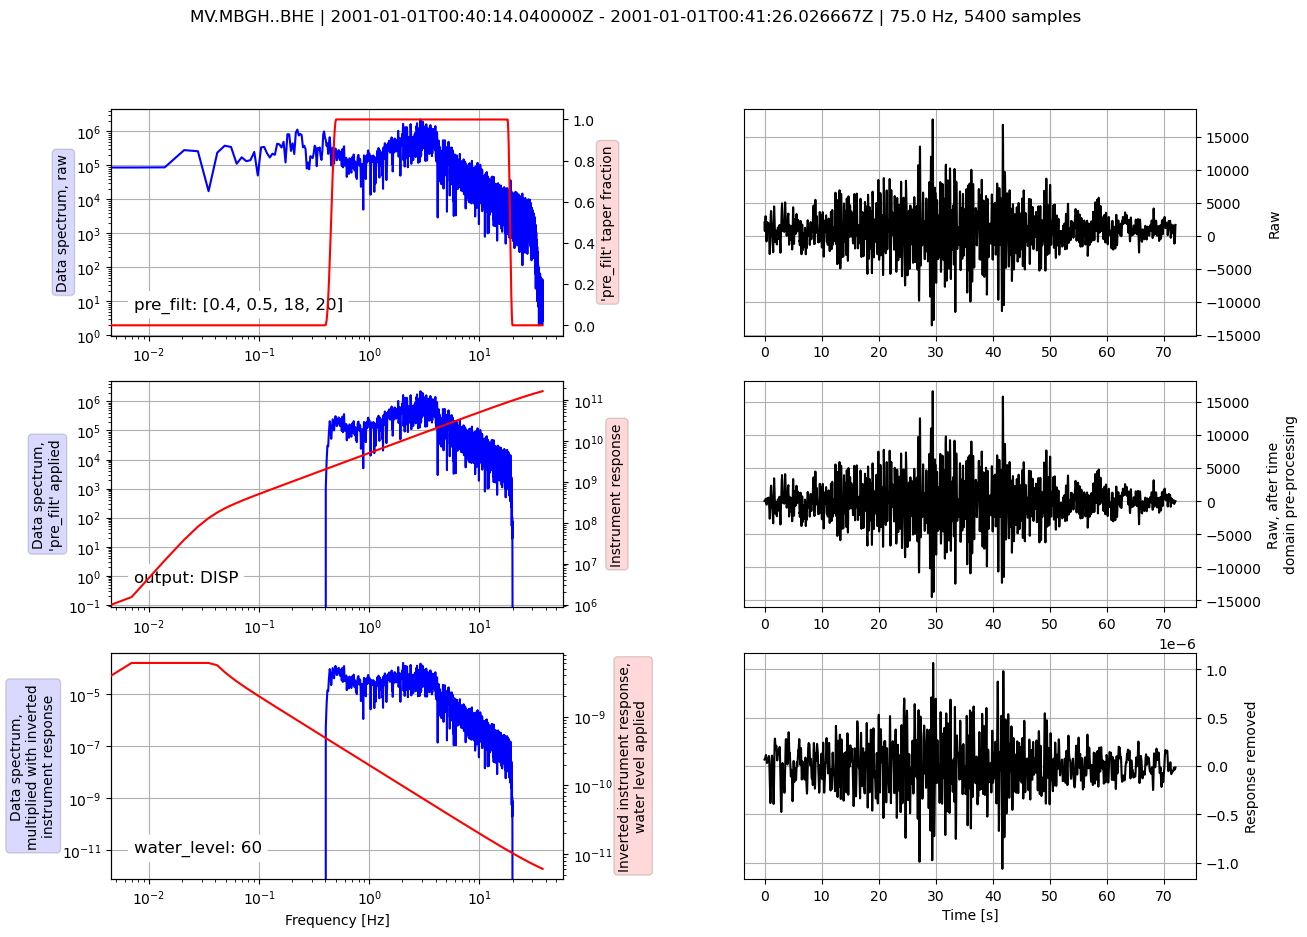

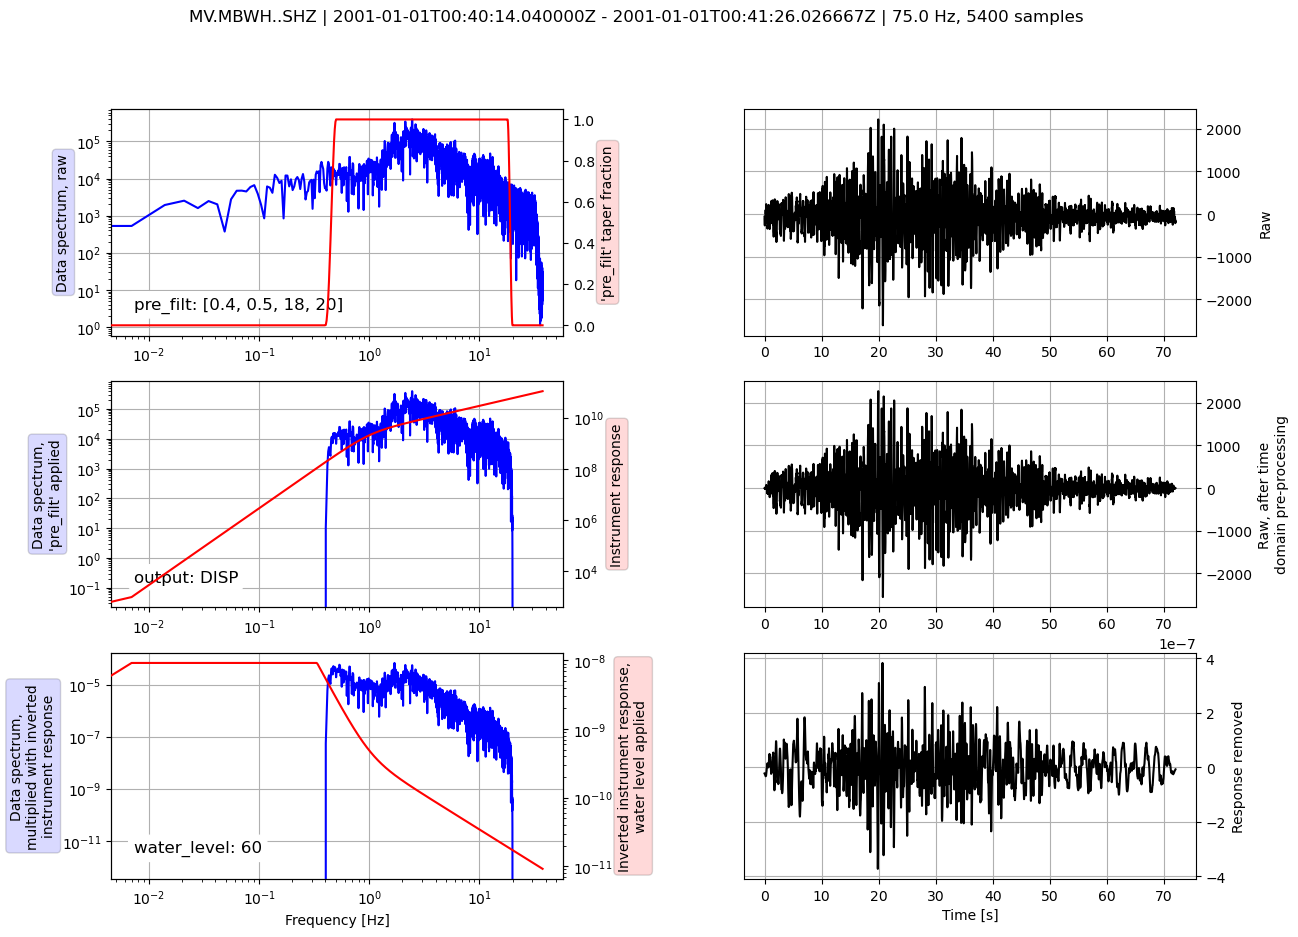

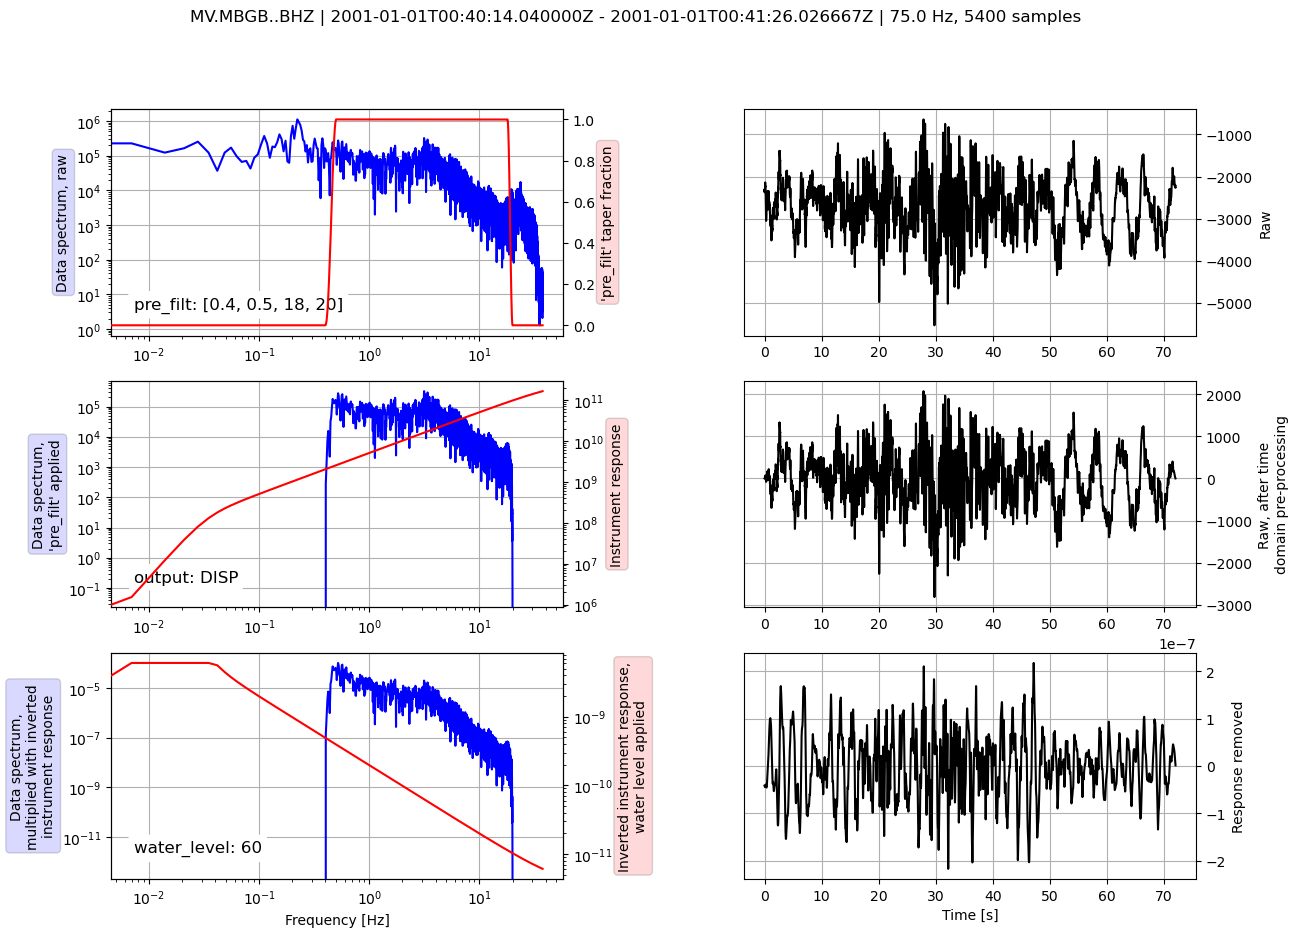

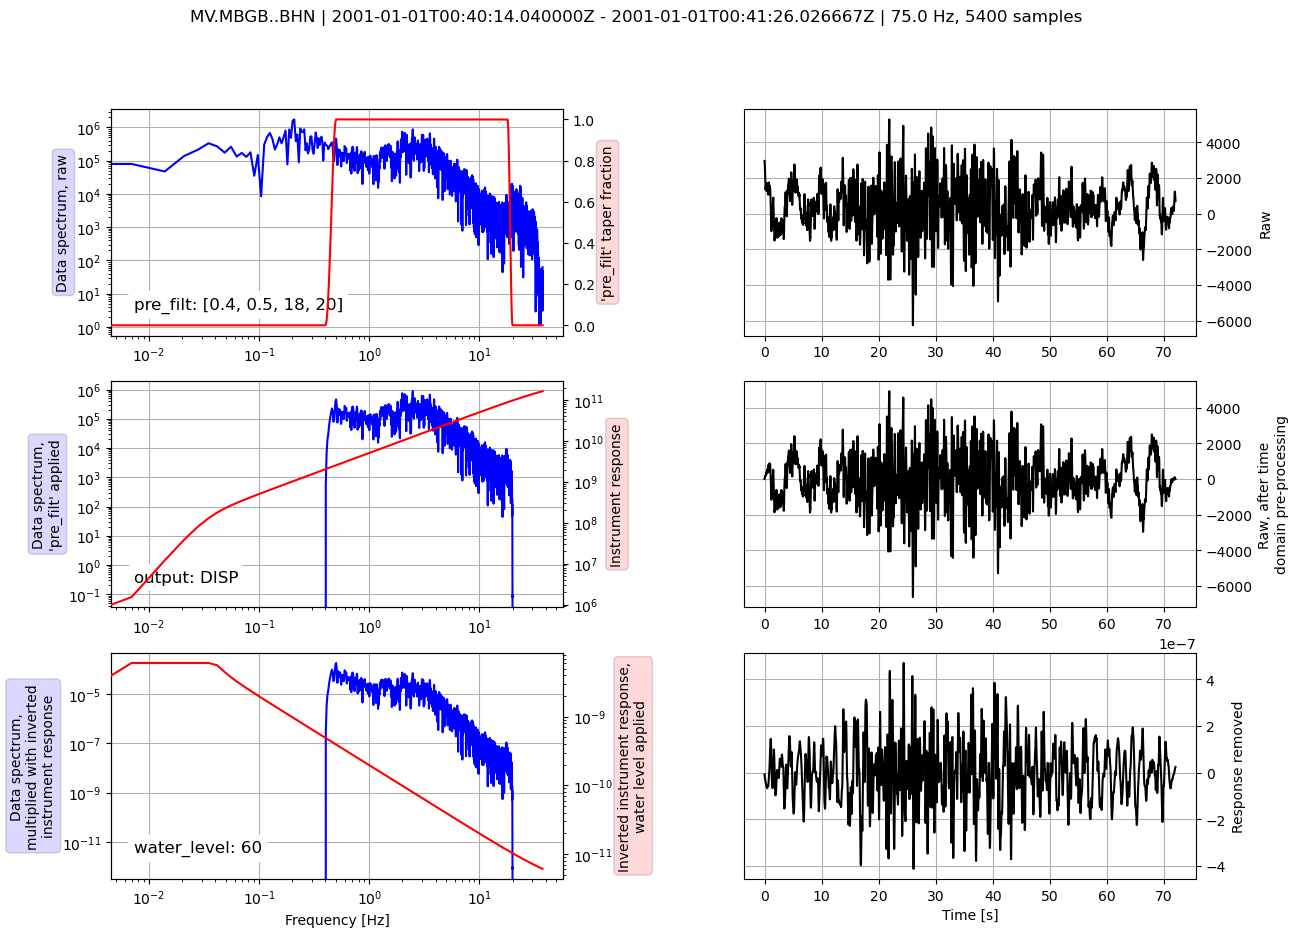

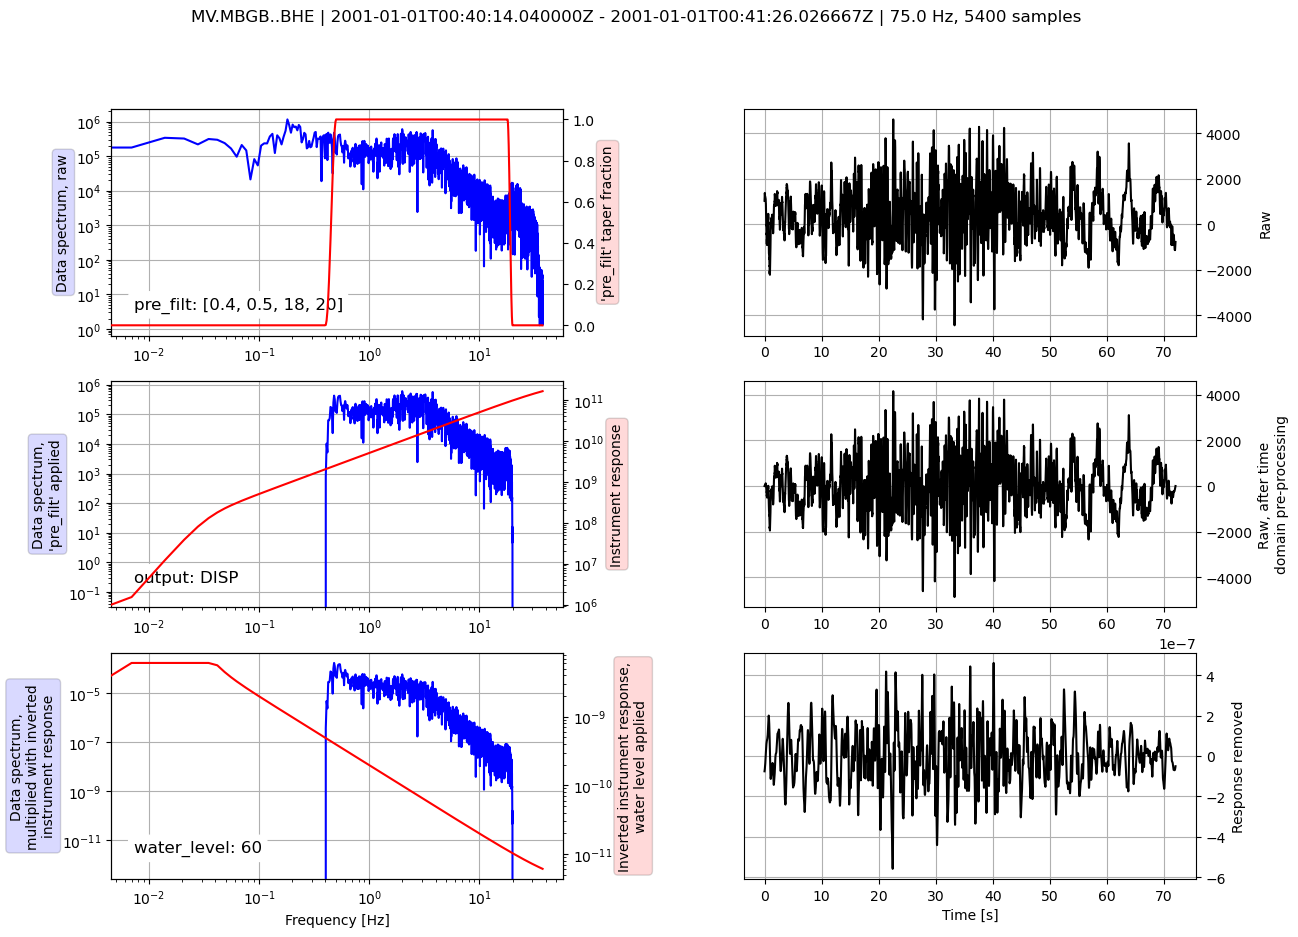

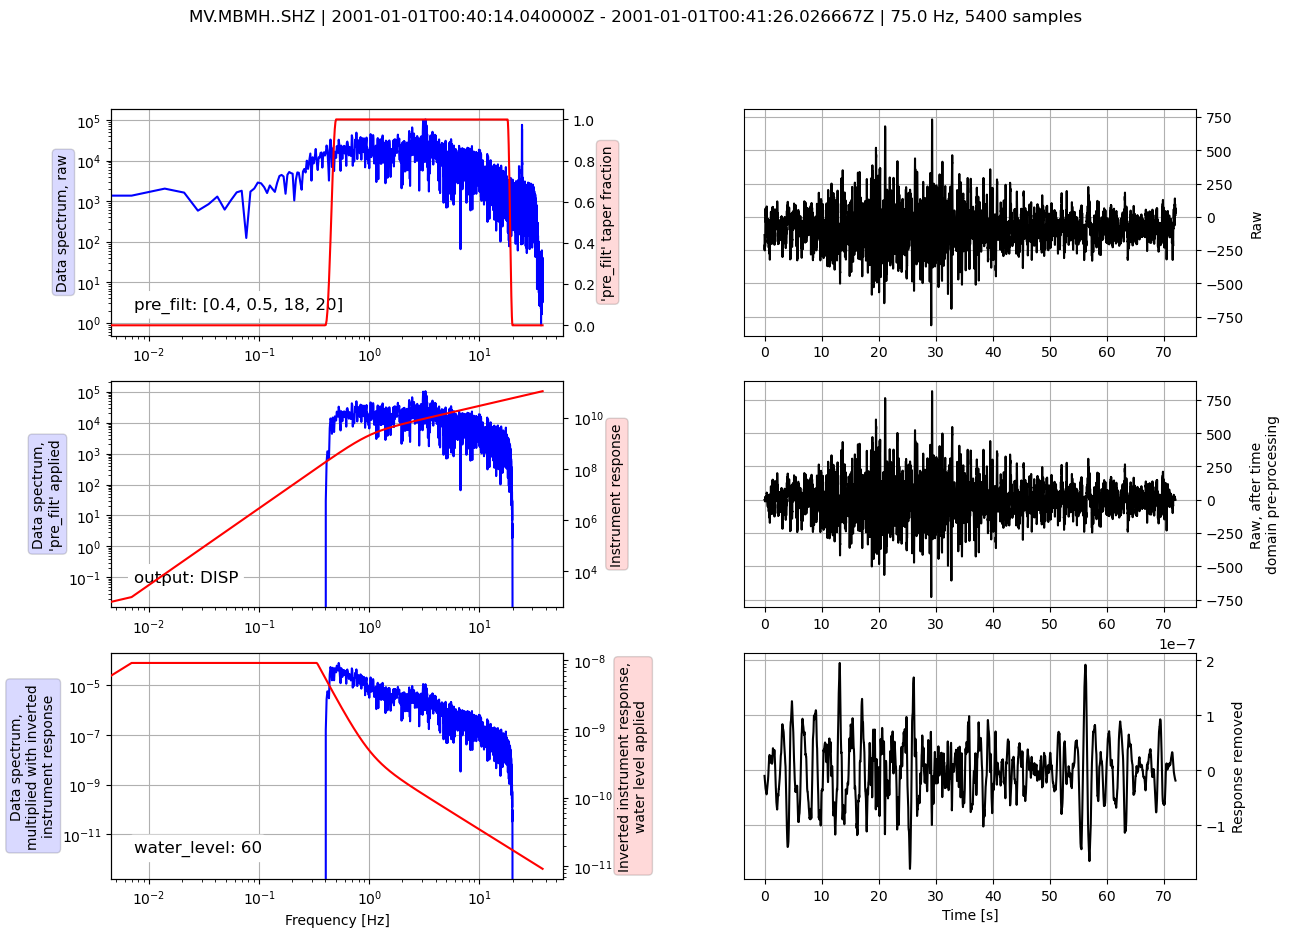

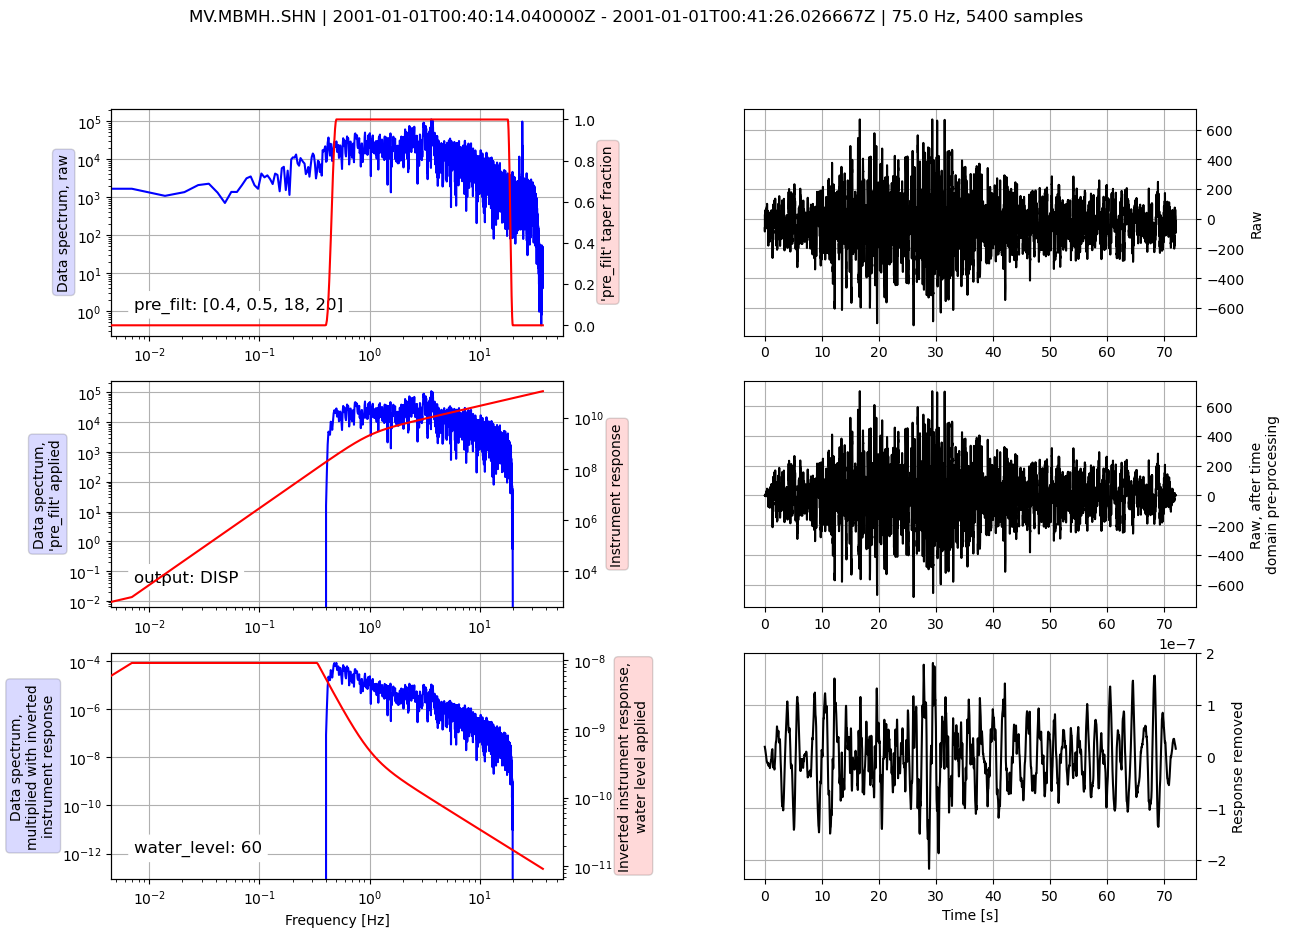

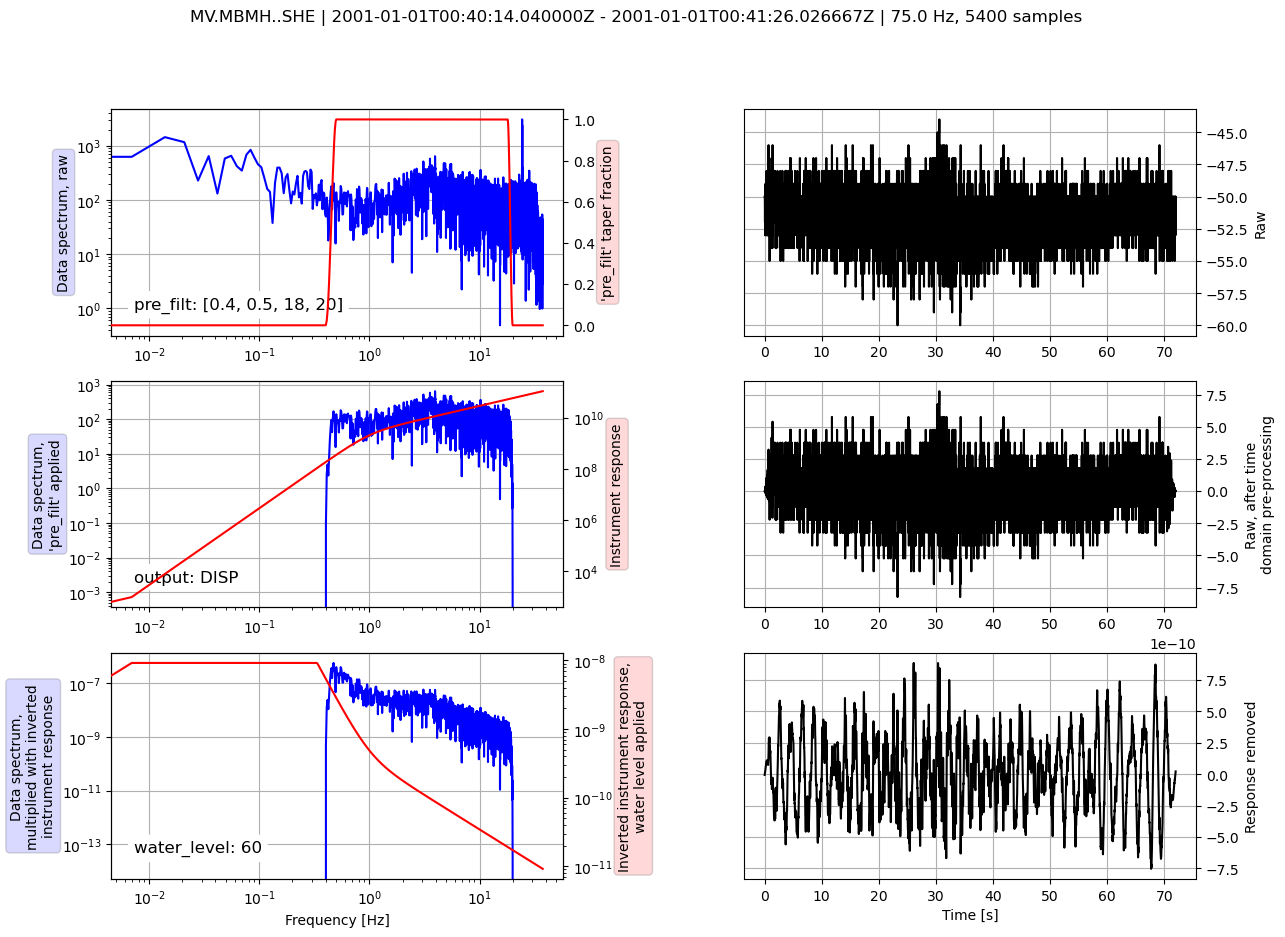

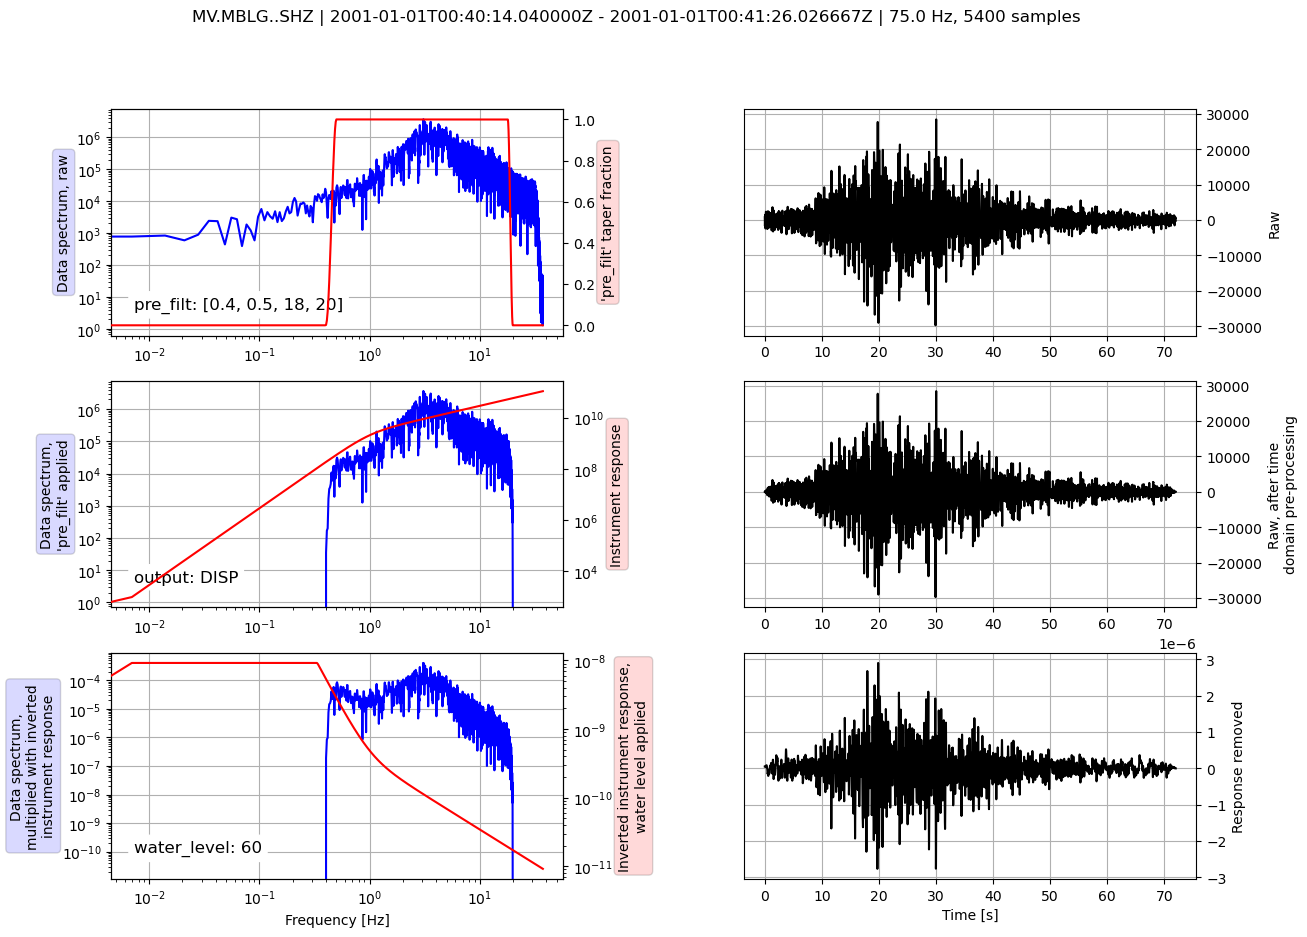

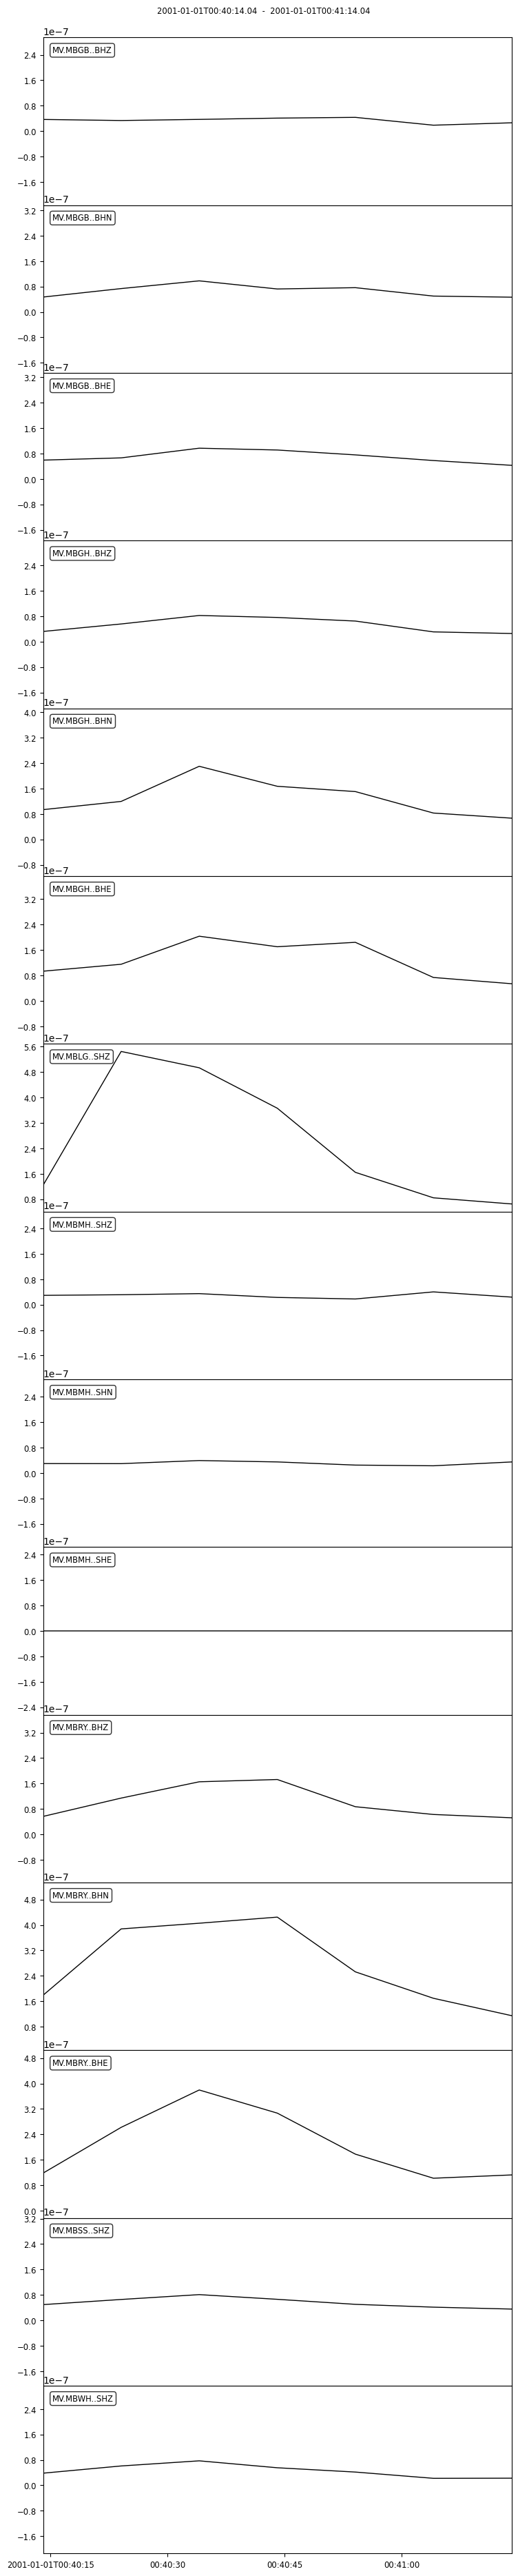

Maximum DRS assuming fixed source is: 0.64
METRIC:  mean
0.7779640253029448
1.9311081906470904
1.9632714433946823
0.6748280128705415
nan
nan
nan
0.5155268413930323
1.6328984404253846
1.4309012446288245
0.6479823860245766
0.6918652433551775
1.5183910031271084
1.3397221852713557
0.6828466165572774
1.00331053627165
0.004242278248568193
0.9723479466822256


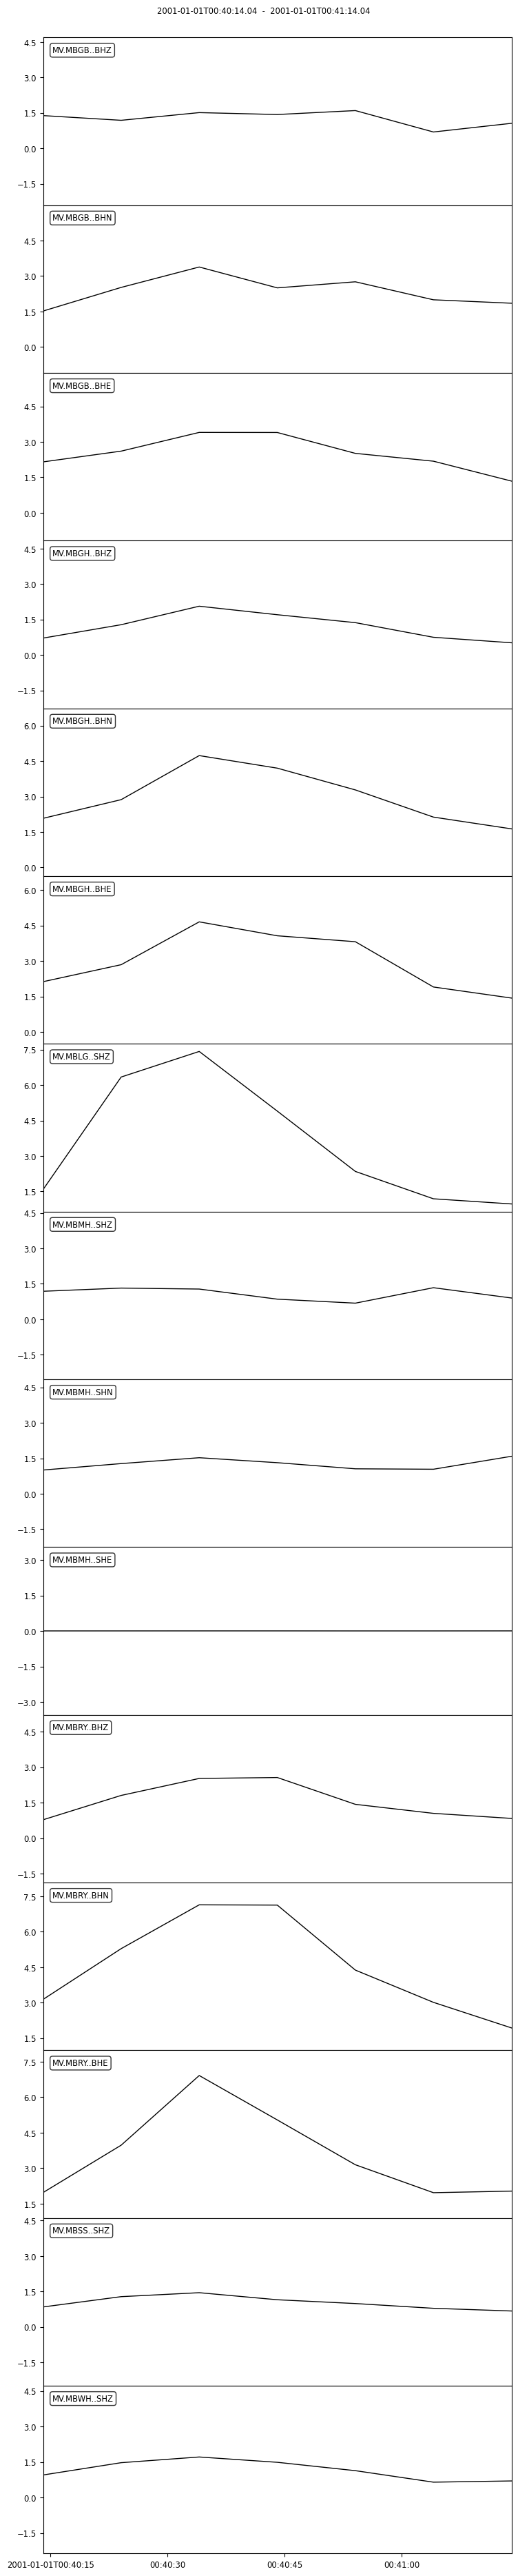

6.386476826095569e-08
1.4510797058267484e-07
1.517823122915154e-07
4.977606238665807e-08
nan
nan
nan
3.048741598312029e-08
8.938183559903832e-08
8.043209514295779e-08
3.266647121807877e-08
2.601114280899708e-08
5.824836208453123e-08
4.9364952991641175e-08
2.2110023775835115e-08
3.2842732697568814e-08
1.685838031322388e-10
9.250508836390994e-08


KeyError: 'MV.MBBY..BHZ'

In [17]:
SEISAN_DATA = os.path.join( '/data', 'SEISAN_DB')
#os.chdir(SEISAN_DATA)
DB = 'MVOE_'

def asl_event(st):

    st.plot(equal_scale=False);

    # same parameters as before
    Q = 23
    surfaceWaveSpeed_kms = 1.5 # km/s
    peakf = 8.0

    # same grid as before
    source = {'lat':16.71111, 'lon':-62.17722}
    #node_spacing_m = 20
    node_spacing_m = 100
    grid_size_lat_m = 10000
    grid_size_lon_m = 8000
    nlat = int(grid_size_lat_m/node_spacing_m) + 1
    nlon = int(grid_size_lon_m/node_spacing_m) + 1
    gridobj = Grid(source['lat'], source['lon'], nlat, nlon, node_spacing_m)  

    # Load inventory
    invMVO = obspy.read_inventory(os.path.join(RESPONSE_DIR,'MV.xml'), format='stationxml')

    # remove instrument response - and set units accordingly IMPORTANT!
    pre_filt = [0.4, 0.5, 18, 20]
    #pre_filt = [6.0, 7.0, 9.0, 10.0]
    for tr in st:
        print(tr)
        try:
            tr.remove_response(inventory=invMVO, pre_filt=pre_filt, output="DISP", plot=True) 
        except:
            st.remove(tr)
        else:
            tr.stats['units'] = 'm'
    #st.plot(equal_scale=True);

    # compute DSAM data with 10-s time window
    dsamObj = DSAM(stream=st, sampling_interval=10)
    print(dsamObj)
    dsamObj.plot(metrics='rms', equal_scale=True)
    '''
            # apply instrument response
            
            for tr in st:
                tr.stats.network = 'MN'
                tr.stats.channel += tr.stats.location
                tr.stats.location = ''
                respfile = "MVO/CAL/RESP.%s" % tr.id
                print(" - ", tr.id, respfile, end=" ")
    '''
    source1 = {'lat':16.71111, 'lon':-62.17722}
    DRSobj = dsamObj.compute_reduced_displacement(invMVO, source1, surfaceWaves=True, Q=None, wavespeed_kms=1.5)

    DRSmaxrms = DRSobj.max(metric='VT')
    print(f'Maximum DRS assuming fixed source is: {DRSmaxrms}')
    DRSobj.plot(equal_scale=True)   

    aslobj = ASL(dsamObj, 'VT', invMVO, gridobj)

    aslobj.compute_grid_distances()

    aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=None, fix_peakf = peakf)

    source_pf = aslobj.fast_locate()

    aslobj.plot(source_pf, zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, equal_size=True, add_labels=False) 

import glob
import seisan_classes
import libSeisan2Pandas as seisan
import libMVO 
#read_monty_wavfile_and_correct_traceIDs(wavpath, bool_ASN=False)
startdate = obspy.UTCDateTime(2001,1,1)
enddate = obspy.UTCDateTime(2001,1,5)
nordicfilelist = seisan.get_sfile_list(SEISAN_DATA, DB, startdate, enddate) 
print(nordicfilelist) 
for nfile in nordicfilelist:
    try:
        s = seisan_classes.Sfile(nfile, fast_mode=True)
        d = s.to_dict()
        display(d)
        sfileindex_dict = {'sfile':os.path.basename(s.path), 'DSN_wavfile':None, 'DSN_exists':False, 'ASN_wavfile':None, 'ASN_exists':False, 'corrected_DSN_mseed':None, 'corrected_ASN_mseed':None, 'mainclass':s.mainclass, 'subclass':s.subclass}
    except:
        continue

    for item in ['wavfile1', 'wavfile2']:
        wavfile = d[item]
        if wavfile and 'MVO' in os.path.basename(wavfile):
            st = obspy.Stream()
            if os.path.isfile(wavfile):
                #try:
                st = libMVO.read_monty_wavfile_and_correct_traceIDs(wavfile, bool_ASN=False)
                print(st)
                #except:
                #    print(f'could not load {wavfile}')
            else:
                altbase = os.path.basename(wavfile).split('.')[0][0:-3]
                pattern = os.path.join(os.path.dirname(wavfile), altbase+'*')
                similar_wavfiles = glob.glob(pattern)
                if len(similar_wavfiles)==1:
                    wavfile = similar_wavfiles[0]
                    #try:
                    st = libMVO.read_monty_wavfile_and_correct_traceIDs(wavfile, bool_ASN=False)
                    print(st)
                    #except:
                    #    print(f'could not load {wavfile}')    
                else:
                    print(f'got {len(similar_wavfiles)} similar wavfiles matching {pattern}')                
                #print(f'no such file {wavfile}')
            if len(st) > 0:
                asl_event(st)

    #display(sfileindex_dict)         

In [ ]:
source1 = {'lat':16.71111, 'lon':-62.17722}
DRSobj = dsamObj.compute_reduced_displacement(invMVO, source1, surfaceWaves=True, Q=None, wavespeed_kms=1.5)

DRSmaxrms = DRSobj.max(metric='VT')
print(f'Maximum DRS assuming fixed source is: {DRSmaxrms}')
DRSobj.plot(equal_scale=True)

In [ ]:
aslobj = ASL(dsamObj, 'VT', invMVO, gridobj)

aslobj.compute_grid_distances()

aslobj.compute_amplitude_corrections(surfaceWaves=True, wavespeed_kms=surfaceWaveSpeed_kms, Q=None, fix_peakf = peakf)

source_pf = aslobj.fast_locate()

aslobj.plot(source_pf, zoom_level=1, threshold_DR=0.03, scale=0.2, join=True, number=10, equal_size=True, add_labels=False)

In [ ]:
aslobj.plot(source_pf, zoom_level=3, threshold_DR=0.03, scale=0.5, join=True, number=30, add_labels=False)

## 5. Summary

I call the approach above "naive" ASL, because for simplicity (and speed, for real-time application) it ignores the vertical dimension, and assumes a homogeneous, isotropic half space (1-layer). It also considers the seismic source to be a point source, and assumes only one event is occurring at a time. In reality, pyroclastic flows cause multiple seismic sources per unit time, over an extended area, and this evolves with time as the flow moves downhill. Moreover, there can be numerous pyroclastic flows travelling down different flanks of the volcano at the same time, such as in a major dome collapse which may be comprised of dozens of pyroclastic flows that reach the coast. The average location determined by ASL is likely the top of the dome. 

In [ ]:
'''
# Define a source location for Redoubt volcano. Station distances to this lat/lon are used to "reduce" the displacement to 1 km distance.
source = {'lat':60.4845, 'lon':-152.7392}
print(source)

# Generate a Reduced Displacement object, assuming body waves (surfaceWaves=False) and no inelastic attenuation (Q=None)
DRobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=False, Q=None)
DRobj.plot()

# Generate a Reduced Displacement object, assuming surface waves (surfaceWaves=True) and no inelastic attenuation (Q=None)
DRSobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=True, Q=None)
DRSobj.plot()
'''